In [1]:
import torch
import matplotlib.pyplot as plt
from model.vae_cnn import *

In [2]:
USE_GPU = True
dtype = torch.float64

if USE_GPU and torch.cuda.is_available():

    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [3]:
# Plot data
%matplotlib inline

from lib.datautils import *
# plotdata("realAdExchange")

In [4]:
# Test forward path for VAE
N = 32
C = 2
L = 64
H = 20
vae_test = VAE(C,
          H, 
          hidden_channels=[3,4,5,5,5,6], 
          up_down_sampling=[False, True, True, False, True], 
          L_in=L 
          ).to(device)
print(vae_test(torch.rand((N, C, L), device=device), device)[0].shape)

tensor([[ 1.6314,  0.1437,  0.8020,  0.5788,  0.0829,  0.2013, -1.1378, -0.5903,
         -2.0378,  0.3091,  0.6616,  0.0748,  0.7889,  0.0527, -2.0930, -0.4946,
          0.4242,  0.7137, -1.1932, -0.5801],
        [-0.5810, -0.1950,  0.8300,  0.2176, -0.1053, -0.0911, -1.1765,  1.2515,
         -0.4458,  0.0754, -0.9778, -0.5050,  1.5116, -0.2470,  1.3198,  0.2516,
         -0.5892, -0.5579,  1.7907,  2.7776],
        [-1.3277, -0.3529,  0.6782, -1.1667, -0.2573, -0.6445,  0.7153,  1.4629,
         -0.6939, -0.4183, -0.1054,  0.9030,  0.1076, -0.2190, -1.8257,  0.7546,
          0.9458,  0.1077, -0.6838, -0.1699],
        [ 1.6306, -0.4022, -1.2459, -0.5757, -0.8661, -0.5965,  0.2232, -1.4274,
         -0.5055, -0.8197,  1.9050,  0.5438,  2.2941,  1.1242,  1.8479, -0.1286,
          0.3697,  0.0951, -0.4650,  0.4259],
        [ 0.8591, -2.3717, -1.9032,  0.8276,  2.0883,  0.0949,  1.2834, -0.9627,
         -0.3038,  0.1492,  0.8579, -0.6907,  0.3240, -0.2948,  1.3647,  1.5757,
      

In [5]:
# Prepare data for training
# X = get_data("realAdExchange")
# print(X.shape)

data_file_list = ["./data/NAB/data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/NAB/data/realAdExchange/exchange-2_cpm_results.csv"]
X_train = None
for data_file in data_file_list:
  Error = None

  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['value'])
      print('Number of samples: ', x.shape[0])
      if X_train == None:
        X_train = torch.from_numpy(x.reshape(1,1,-1).astype(np.float32))
      else:
        X_train = torch.cat((X_train, torch.from_numpy(x.reshape(1, 1, -1).astype(np.float32))), dim=1)
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)
X_test = X_train[:,:,1400:1623]
X_train= X_train[:,:,0   :1400]

Number of samples:  1624
Number of samples:  1624


In [6]:
# Loss function
def loss_fn(model, sample, x_hat, muy, log_var, alpha):
  # reg = 0.0
  # for parameter in model.parameters():
  #   reg += torch.mean(parameter)
  reconstruction_loss = torch.mean((sample - x_hat)**2)
  KLD_loss = -0.5*torch.mean(1 + log_var - muy**2 - log_var.exp())
  reconstruction_total = reconstruction_loss/(alpha*KLD_loss)
  loss = reconstruction_loss + alpha*KLD_loss
  return loss, reconstruction_total

In [7]:
# Overfit a sample 
def train_overfit(model, opt, X_trai, device, reg=0.1, max_iteration=100, sample_length=32):
  model.to(device)
  model.train()
  sample = X_train[0:1,:,0:sample_length].to(device)
  # print(sample)
  loss_hist = []
  muy_hist = []
  logvar_hist = []
  for iter in range(max_iteration):
    x_hat, muy, log_var = model(sample, device)
    loss, _ = loss_fn(model, sample, x_hat, muy, log_var, reg)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_hist.append(loss.item())
  plt.plot(list(np.arange(len(loss_hist))), loss_hist)
  plt.show()


.4644, -0.0812, -0.2290, -0.5486,  0.3064, -0.9958,
         -0.8859, -1.2855]], device='cuda:0')
torch.Size([1, 10])
tensor([[ 0.9056, -2.5320,  1.6475, -1.1848,  0.8071,  0.8012,  0.4260, -0.1721,
         -0.3569,  0.5577]], device='cuda:0')
torch.Size([1, 10])
tensor([[-0.2577, -0.7229,  0.7549,  0.5172, -0.8521,  1.4207, -0.4796,  1.0833,
          1.1347,  0.3605]], device='cuda:0')
torch.Size([1, 10])
tensor([[ 0.0055,  1.0269, -1.0820,  0.3950,  0.2912, -0.3573, -0.6467,  0.8053,
          1.4049,  0.2993]], device='cuda:0')
torch.Size([1, 10])
tensor([[ 0.9124, -0.8252,  1.1831,  1.9261,  0.3715,  0.0277, -0.2624, -0.9501,
         -0.4859,  0.4229]], device='cuda:0')
torch.Size([1, 10])
tensor([[-2.0026, -0.2704,  0.7150, -0.9859,  0.2813,  1.5136, -2.0356,  0.6099,
         -0.8787,  2.0461]], device='cuda:0')
torch.Size([1, 10])
tensor([[ 1.4482, -0.3517, -0.3852,  0.2957, -0.0269, -2.2633, -0.8629, -1.2636,
         -0.3004, -0.1646]], device='cuda:0')
torch.Size([1, 10])


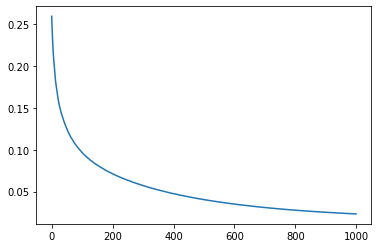

tensor([[ 0.0403, -0.0048,  0.0376,  0.1260,  0.0072, -0.0366,  0.0830,  0.0014,
          0.0046,  0.0166]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.1080, -0.0264,  0.0313,  0.1145, -0.0565, -0.0041, -0.1044,  0.0635,
          0.1285, -0.2591]], device='cuda:0', grad_fn=<SliceBackward>)


In [8]:
N = 1
C = 2
L = 32*5
H = 10
 
vae_overfit = VAE(C, H, hidden_channels=[4,16, 16,16, 32], up_down_sampling=[False, True, True, False], L_in=L)
print(vae_overfit)
# Optimizer for overfit tranning
optim = torch.optim.SGD(vae_overfit.parameters(), lr=1e-3)
train_overfit(vae_overfit, optim, X_train, device, max_iteration=1000, sample_length=L)
print(vae_overfit.muy)
print(vae_overfit.log_var)

In [32]:
def train(model, opt, device, alpha=0.01, epochs=1, sample_length=32, batch_size=32):
  model.to(device)
  model.train()
  sample = torch.zeros((batch_size, 2, sample_length)).to(device=device)
  L = X_train.shape[2]
  loss_hist = []
  muy_hist = []
  min_loss = 1000
  raito = 0.0
  for e in range(epochs):
    for batch in range(int(X_train.shape[2]/batch_size)):
      for i in range(batch_size):
        start = np.random.randint(0,L - sample_length)
        sample[i,:,:] = X_train[0,:,start:start + sample_length]
      x_hat, muy, log_var = model(sample, device)
      loss, raito = loss_fn(model, sample, x_hat, muy, log_var, alpha)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if loss.item() < min_loss:
        min_loss = loss.item()
      if loss_hist:
        loss_hist.append(loss.item()*0.1 + loss_hist[-1]*0.9)
      else:
        loss_hist.append(loss.item())
    print('muy = ', muy)
    print('sugma = ', log_var)
      # muy_hist.append(muy_hist[-1]*0.9 + muy)
    print(raito.item())
    print('epoch: ', e, ' min loss = ', min_loss, 'evg loss ', loss_hist[-1])
    plt.plot(list(np.arange(len(loss_hist))), loss_hist)
    plt.show()

In [35]:
N = 16
C = 2
L = 64
H = 128

vae = VAE(C, 
          H, 
          hidden_channels=[4,8,16], 
          up_down_sampling=[False, True], 
          L_in=L
      )


In [36]:
optim = torch.optim.Adam(vae.parameters(), lr=5e-4, weight_decay=0.9)

muy =  tensor([[ 0.0598, -0.2243, -0.0429,  ...,  0.0216, -0.1842,  0.1879],
        [ 0.0610, -0.2231, -0.0458,  ...,  0.0248, -0.1806,  0.1890],
        [ 0.0586, -0.2206, -0.0438,  ...,  0.0224, -0.1837,  0.1865],
        ...,
        [ 0.0636, -0.2249, -0.0482,  ...,  0.0241, -0.1787,  0.1890],
        [ 0.0604, -0.2206, -0.0473,  ...,  0.0252, -0.1814,  0.1858],
        [ 0.0619, -0.2233, -0.0466,  ...,  0.0243, -0.1793,  0.1886]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0573,  0.3217,  0.0196,  ...,  0.0214,  0.0108, -0.0896],
        [-0.0570,  0.3234,  0.0208,  ...,  0.0190,  0.0110, -0.0930],
        [-0.0578,  0.3193,  0.0214,  ...,  0.0179,  0.0102, -0.0907],
        ...,
        [-0.0595,  0.3224,  0.0204,  ...,  0.0199,  0.0112, -0.0920],
        [-0.0546,  0.3208,  0.0225,  ...,  0.0193,  0.0096, -0.0942],
        [-0.0574,  0.3236,  0.0205,  ...,  0.0187,  0.0117, -0.0938]],
       device='cuda:0', grad_fn=<SliceBackward>)
2.9917213916778564

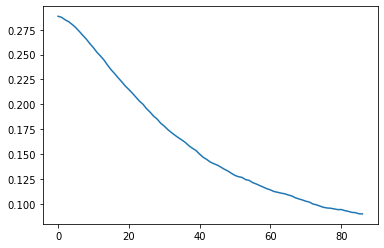

muy =  tensor([[ 0.0472, -0.0987, -0.0083,  ..., -0.0228, -0.0938,  0.1168],
        [ 0.0464, -0.0983, -0.0082,  ..., -0.0231, -0.0940,  0.1162],
        [ 0.0470, -0.0990, -0.0083,  ..., -0.0227, -0.0936,  0.1170],
        ...,
        [ 0.0469, -0.0989, -0.0076,  ..., -0.0232, -0.0939,  0.1170],
        [ 0.0471, -0.0984, -0.0086,  ..., -0.0228, -0.0939,  0.1167],
        [ 0.0471, -0.0991, -0.0079,  ..., -0.0235, -0.0939,  0.1169]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0302,  0.1408, -0.0096,  ..., -0.0082,  0.0116, -0.0861],
        [-0.0301,  0.1408, -0.0095,  ..., -0.0084,  0.0116, -0.0862],
        [-0.0306,  0.1407, -0.0096,  ..., -0.0078,  0.0115, -0.0857],
        ...,
        [-0.0306,  0.1402, -0.0095,  ..., -0.0076,  0.0111, -0.0854],
        [-0.0303,  0.1406, -0.0096,  ..., -0.0082,  0.0118, -0.0862],
        [-0.0308,  0.1400, -0.0093,  ..., -0.0075,  0.0111, -0.0853]],
       device='cuda:0', grad_fn=<SliceBackward>)
8.991765975952148


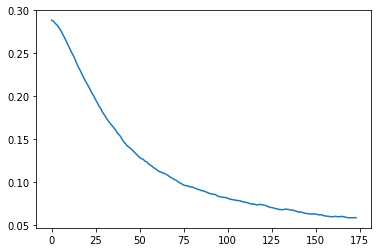

muy =  tensor([[ 0.0216, -0.0433,  0.0087,  ..., -0.0237, -0.0451,  0.0757],
        [ 0.0218, -0.0434,  0.0086,  ..., -0.0236, -0.0451,  0.0757],
        [ 0.0217, -0.0433,  0.0087,  ..., -0.0236, -0.0451,  0.0757],
        ...,
        [ 0.0217, -0.0434,  0.0087,  ..., -0.0237, -0.0450,  0.0757],
        [ 0.0217, -0.0433,  0.0086,  ..., -0.0237, -0.0451,  0.0757],
        [ 0.0218, -0.0433,  0.0086,  ..., -0.0236, -0.0451,  0.0757]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0179,  0.0600, -0.0077,  ..., -0.0117,  0.0004, -0.0521],
        [-0.0179,  0.0600, -0.0077,  ..., -0.0116,  0.0004, -0.0521],
        [-0.0179,  0.0600, -0.0077,  ..., -0.0117,  0.0004, -0.0521],
        ...,
        [-0.0179,  0.0600, -0.0076,  ..., -0.0118,  0.0003, -0.0521],
        [-0.0178,  0.0600, -0.0076,  ..., -0.0117,  0.0004, -0.0522],
        [-0.0178,  0.0600, -0.0077,  ..., -0.0117,  0.0004, -0.0521]],
       device='cuda:0', grad_fn=<SliceBackward>)
23.754234313964844

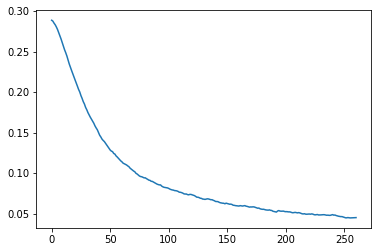

muy =  tensor([[ 0.0098, -0.0162,  0.0086,  ..., -0.0153, -0.0209,  0.0508],
        [ 0.0098, -0.0162,  0.0086,  ..., -0.0154, -0.0209,  0.0508],
        [ 0.0098, -0.0162,  0.0086,  ..., -0.0154, -0.0209,  0.0508],
        ...,
        [ 0.0098, -0.0162,  0.0086,  ..., -0.0153, -0.0209,  0.0508],
        [ 0.0098, -0.0162,  0.0086,  ..., -0.0153, -0.0209,  0.0508],
        [ 0.0098, -0.0162,  0.0086,  ..., -0.0154, -0.0209,  0.0508]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0114,  0.0249, -0.0026,  ..., -0.0080, -0.0043, -0.0260],
        [-0.0114,  0.0249, -0.0026,  ..., -0.0079, -0.0043, -0.0260],
        [-0.0114,  0.0249, -0.0026,  ..., -0.0080, -0.0043, -0.0260],
        ...,
        [-0.0114,  0.0249, -0.0026,  ..., -0.0080, -0.0043, -0.0260],
        [-0.0114,  0.0249, -0.0026,  ..., -0.0079, -0.0043, -0.0260],
        [-0.0114,  0.0249, -0.0026,  ..., -0.0079, -0.0043, -0.0260]],
       device='cuda:0', grad_fn=<SliceBackward>)
52.157379150390625

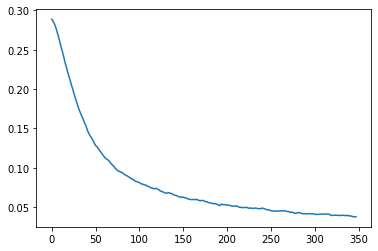

muy =  tensor([[ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330],
        [ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330],
        [ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330],
        ...,
        [ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330],
        [ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330],
        [ 0.0046, -0.0050,  0.0050,  ..., -0.0078, -0.0096,  0.0330]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-6.3367e-03,  9.6972e-03, -4.9070e-05,  ..., -4.1396e-03,
         -4.8258e-03, -1.1087e-02],
        [-6.3402e-03,  9.6963e-03, -4.7435e-05,  ..., -4.1352e-03,
         -4.8312e-03, -1.1088e-02],
        [-6.3391e-03,  9.6952e-03, -4.7336e-05,  ..., -4.1363e-03,
         -4.8290e-03, -1.1089e-02],
        ...,
        [-6.3407e-03,  9.6968e-03, -4.7946e-05,  ..., -4.1328e-03,
         -4.8314e-03, -1.1086e-02],
        [-6.3367e-03,  9.6953e-03, -4.7332e-05,  ..., -4.1343e-03,
         

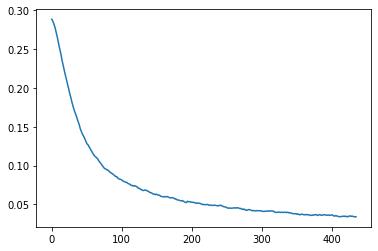

muy =  tensor([[ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207],
        [ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207],
        [ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207],
        ...,
        [ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207],
        [ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207],
        [ 0.0024, -0.0013,  0.0024,  ..., -0.0034, -0.0042,  0.0207]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042],
        [-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042],
        [-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042],
        ...,
        [-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042],
        [-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042],
        [-0.0032,  0.0034,  0.0005,  ..., -0.0018, -0.0037, -0.0042]],
       device='cuda:0', grad_fn=<SliceBackward>)
278.1065979003906


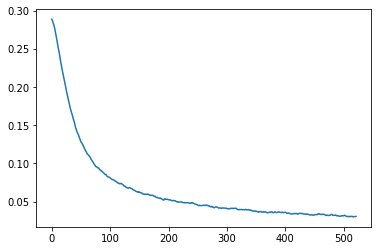

muy =  tensor([[ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124],
        [ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124],
        [ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124],
        ...,
        [ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124],
        [ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124],
        [ 0.0012, -0.0003,  0.0010,  ..., -0.0013, -0.0017,  0.0124]],
       device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014],
        [-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014],
        [-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014],
        ...,
        [-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014],
        [-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014],
        [-0.0015,  0.0011,  0.0004,  ..., -0.0007, -0.0023, -0.0014]],
       device='cuda:0', grad_fn=<SliceBackward>)
576.799560546875
e

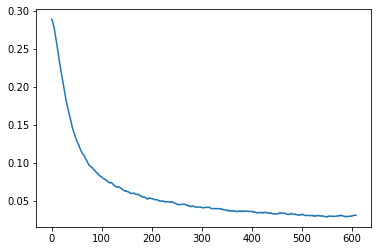

muy =  tensor([[ 5.7605e-04, -1.3137e-05,  4.0528e-04,  ..., -4.6851e-04,
         -6.2148e-04,  7.0697e-03],
        [ 5.7605e-04, -1.3121e-05,  4.0528e-04,  ..., -4.6852e-04,
         -6.2147e-04,  7.0697e-03],
        [ 5.7605e-04, -1.3122e-05,  4.0527e-04,  ..., -4.6853e-04,
         -6.2146e-04,  7.0698e-03],
        ...,
        [ 5.7606e-04, -1.3131e-05,  4.0527e-04,  ..., -4.6851e-04,
         -6.2147e-04,  7.0698e-03],
        [ 5.7606e-04, -1.3122e-05,  4.0527e-04,  ..., -4.6851e-04,
         -6.2147e-04,  7.0698e-03],
        [ 5.7605e-04, -1.3121e-05,  4.0527e-04,  ..., -4.6851e-04,
         -6.2148e-04,  7.0698e-03]], device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-0.0006,  0.0003,  0.0002,  ..., -0.0003, -0.0012, -0.0004],
        [-0.0006,  0.0003,  0.0002,  ..., -0.0003, -0.0012, -0.0004],
        [-0.0006,  0.0003,  0.0002,  ..., -0.0003, -0.0012, -0.0004],
        ...,
        [-0.0006,  0.0003,  0.0002,  ..., -0.0003, -0.0012, -0.0004],
        [-0.0006,

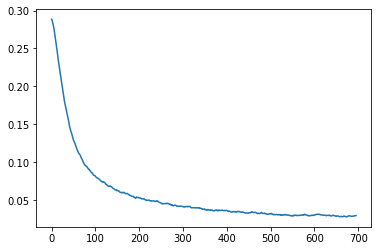

muy =  tensor([[ 2.5913e-04,  2.0927e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03],
        [ 2.5913e-04,  2.0928e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03],
        [ 2.5913e-04,  2.0928e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03],
        ...,
        [ 2.5913e-04,  2.0928e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03],
        [ 2.5913e-04,  2.0928e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03],
        [ 2.5913e-04,  2.0927e-05,  1.4641e-04,  ..., -1.4675e-04,
         -2.0395e-04,  3.7860e-03]], device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-2.4985e-04,  9.2901e-05,  1.0098e-04,  ..., -8.9250e-05,
         -5.8940e-04, -1.2550e-04],
        [-2.4985e-04,  9.2901e-05,  1.0098e-04,  ..., -8.9251e-05,
         -5.8941e-04, -1.2550e-04],
        [-2.4985e-04,  9.2900e-05,  1.0098e-04,  ..., -8.9251e-05,
         -5.8940e-04, -1.2550e-04],
 

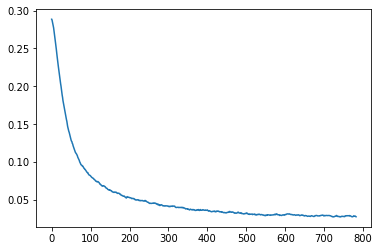

muy =  tensor([[ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03],
        [ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03],
        [ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03],
        ...,
        [ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03],
        [ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03],
        [ 1.0810e-04,  1.4104e-05,  4.8920e-05,  ..., -4.1098e-05,
         -5.9707e-05,  1.9088e-03]], device='cuda:0', grad_fn=<SliceBackward>)
sugma =  tensor([[-9.0664e-05,  2.5607e-05,  4.1959e-05,  ..., -3.0369e-05,
         -2.6153e-04, -3.2934e-05],
        [-9.0664e-05,  2.5607e-05,  4.1959e-05,  ..., -3.0369e-05,
         -2.6153e-04, -3.2934e-05],
        [-9.0665e-05,  2.5607e-05,  4.1959e-05,  ..., -3.0369e-05,
         -2.6153e-04, -3.2934e-05],
 

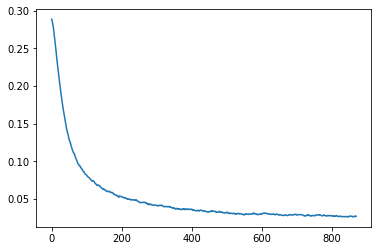

In [37]:
train(vae, optim, epochs=10, alpha=1, batch_size=N,  sample_length=L, device=device)

In [13]:
# X_reconstruct = torch.zeros_like(X_test)
# vae.to(device)
# for i in range(int(X_test.shape[2]/L)-1):
#   X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
#       X_test[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
#   )
# print(X_reconstruct.shape)

In [21]:
# fig=plt.figure(figsize=(30,6), dpi=80)
# plt.plot(np.arange(X_test.shape[2]-100), X_test[0,0,:-100].detach().numpy(), label='Original')
# # plt.legend()
# # plt.show()
# # fig=plt.figure(figsize=(30,6), dpi=80)

# plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)
# error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_test[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_test[0,0,:-100])
# plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
# plt.legend()
plt.show()

torch.Size([1, 2, 1400])


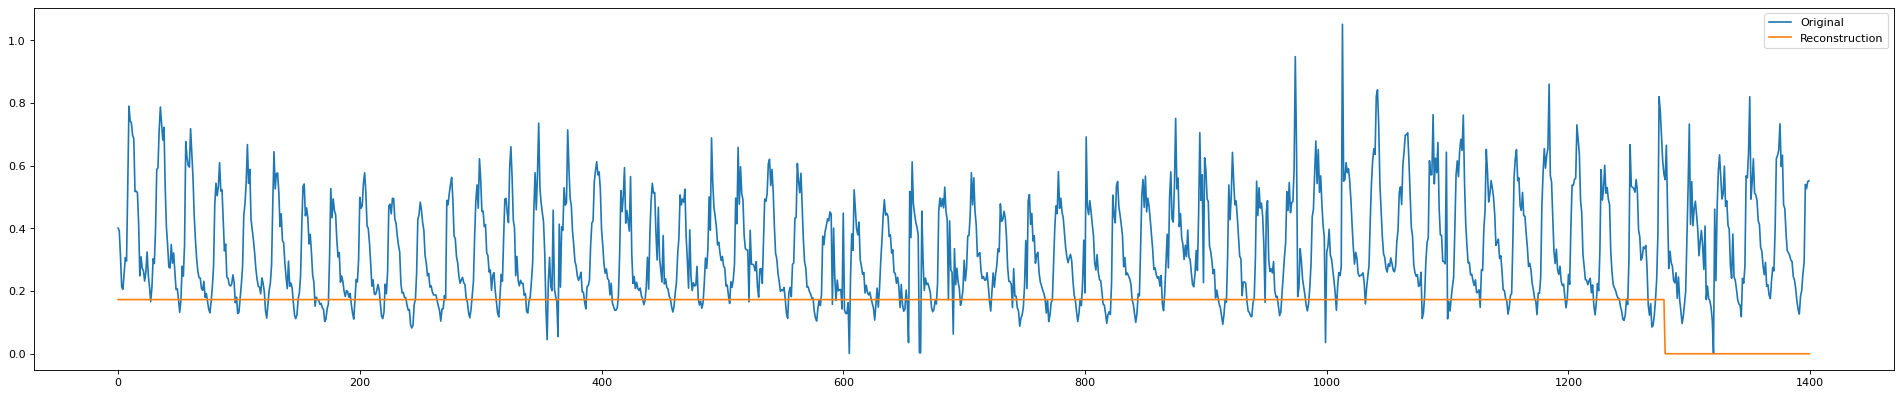

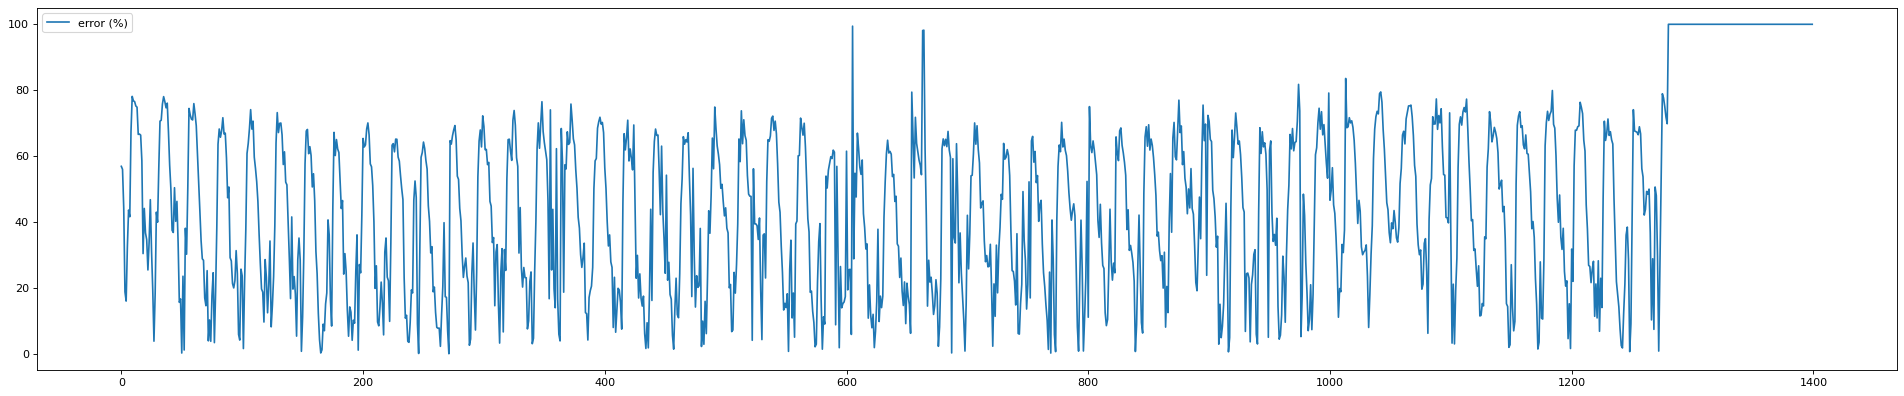

In [30]:
X_reconstruct = torch.zeros_like(X_train)
vae.to(device)
for i in range(int(X_train.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_train[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device),
      device
  )
print(X_reconstruct.shape)
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_train.shape[2]), X_train[0,1,:].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]), X_reconstruct[0,1,:].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,1,:] - X_train[0,1,:])/torch.max(X_reconstruct[0,1,:], X_train[0,1,:])
plt.plot(np.arange(X_reconstruct.shape[2]), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()